In [1]:
# import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///hawaii.sqlite")

# reflect an existing database into a new model
# declare a Base using `automap_base()`
Base = automap_base()

# reflect the tables
# use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [5]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [6]:
# inspect the databases
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# get a list of column names and types for 1st table
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [9]:
# get a list of column names and types for 2nd table
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# determine the last date in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Last Measurement Date: {last_date[0]}")

Last Measurement Date: 2017-08-23


In [12]:
# Calculate the date one year ago from the last data point in the database

year_ago = dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)
print ('Start Date:', year_ago)

Start Date: 2016-08-23 00:00:00


In [13]:
# Perform a query to retrieve the date and precipitation values

data_1_yr = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= year_ago).all()
data_1_yr[:5]

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01)]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(data_1_yr, columns=['Date','Precipitation'])
precip_df = precip_df.set_index("Date")
precip_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [15]:
# Sort the dataframe by date

precip_df = precip_df.sort_values(["Date"], ascending=True).dropna()
precip_df

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


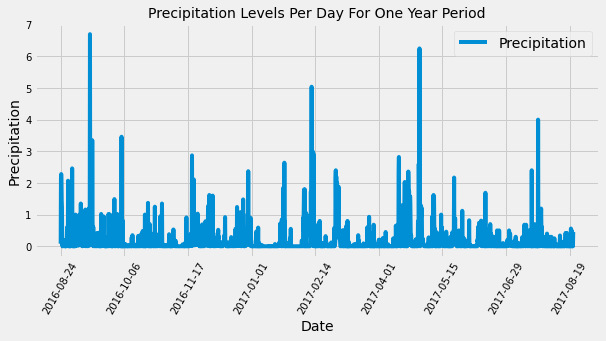

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.rcParams['figure.figsize'] = (9, 4)

precip_df.plot(rot=90)
#y = precip_df["Precipitation"]
#x = precip_df
plt.xticks(fontsize=10, rotation=60)
plt.yticks(fontsize=10)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Precipitation', fontsize=14)
plt.legend(loc='upper right')
plt.title('Precipitation Levels Per Day For One Year Period', fontsize=14)
#plt.bar(range(len(y)), y, color='green', width=0.8, align="center") 
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data

precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_count} weather stations in the dataset.")

There are 9 weather stations in the dataset.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

readings_per_station = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
readings_per_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = readings_per_station[0][0]
most_active

'USC00519281'

In [21]:
temps = [func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]

session.query(*temps).filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_data = session.query(Measurement.tobs).\
                filter(Measurement.date >= year_ago).\
                filter(Measurement.station == most_active).all()

station_data_df = pd.DataFrame(station_data)
station_data_df.head()                                

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


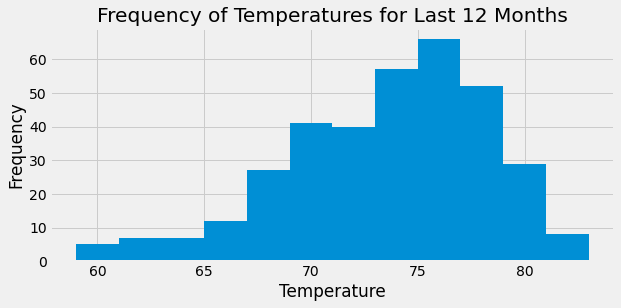

In [23]:
plt.hist(station_data_df["tobs"], bins=12, label="tobs")
plt.title("Frequency of Temperatures for Last 12 Months")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.savefig("images/histogram.png")

## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date
# in the format '%Y-%m-%d' and return the minimum, maximum, and average
# temperatures for that range of dates

def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs),\
                        func.avg(Measurement.tobs),\
                        func.max(Measurement.tobs)).\
                        filter(Measurement.date >= start_date).\
                        filter(Measurement.date <= end_date).all()

print(calc_temps('2017-04-01', '2017-04-14'))

[(67.0, 74.5, 82.0)]


In [25]:
# Another solution that saves output as variables

import datetime as dt

start_date = '2017-04-01'
end_date = '2017-04-14'

print(f"The start date is {start_date} and the end date is {end_date}.")
    
tmin = session.query(func.min(Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date)).all()

tavg = session.query(func.avg(Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date)).all()

tmax = session.query(func.max(Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date)).all()                    
                                
# function usage example
print(f"The minimum, average, and maximum temperatures during this period are: {tmin}, {tavg}, {tmax} respectively.")

The start date is 2017-04-01 and the end date is 2017-04-14.
The minimum, average, and maximum temperatures during this period are: [(67.0,)], [(74.5,)], [(82.0,)] respectively.


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

import datetime as dt

prior_year_start = dt.date(2017, 4, 1) - dt.timedelta(days=365)
prior_year_end = dt.date(2017, 4, 14) - dt.timedelta(days=365)
                           
tmin, tavg, tmax = calc_temps(prior_year_start.strftime("%Y-%m-%d"), prior_year_end.strftime("%Y-%m-%d"))[0]

print(f"The minimum, average, and maximum temperatures during the period between {prior_year_start} and {prior_year_end} are: {tmin}, {tavg}, {tmax}, respectively.")

The minimum, average, and maximum temperatures during the period between 2016-04-01 and 2016-04-14 are: 65.0, 73.25842696629213, 78.0, respectively.


C:\Users\dave\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


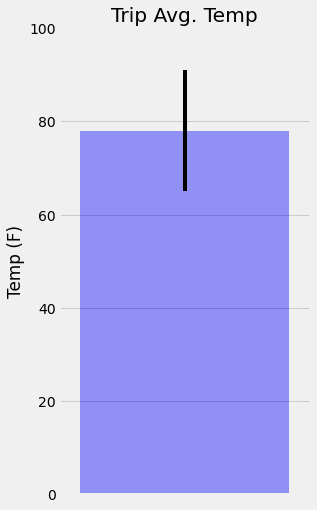

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.4, color='blue', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg. Temp", ylabel="Temp (F)")
ax.margins(.1, .1)
fig.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using 
# the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, 
# latitude, longitude, and elevation.

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= prior_year_start).\
    filter(Measurement.date <= prior_year_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.32), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.6699999999999995), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.3500000000000003), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.47), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.26), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.04), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.03)]


In [29]:
# Create a query that will calculate the daily normals (i.e. the averages for tmin, tmax,
# and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    
#     Daily Normals.
    
#     Args:
#         date (str): A date string in the format '%m-%d'
        
#     Returns:
#         A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

start_date = '2017-04-01'
end_date = '2017-04-14'

# Use the start and end date to create a range of dates

trip_dates = pd.date_range(start_date, end_date, freq='D')

# Strip off the year and save a list of %m-%d strings

trip_month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142857, 77.0),
 (63.0, 71.10526315789474, 78.0),
 (66.0, 72.10526315789474, 77.0),
 (62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0)]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range 
# as the `date` index

trip_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_df['date'] = trip_dates
trip_df.set_index(['date'],inplace=True)
trip_df

,tmin,tavg,tmax
date,,,
2017-04-01,60.0,71.879310,80.0
2017-04-02,53.0,71.821429,79.0
2017-04-03,55.0,72.228070,78.0
2017-04-04,58.0,72.016393,78.0
2017-04-05,61.0,72.288136,80.0
2017-04-06,67.0,71.571429,77.0
2017-04-07,63.0,71.105263,78.0
2017-04-08,66.0,72.105263,77.0
2017-04-09,62.0,71.614035,78.0


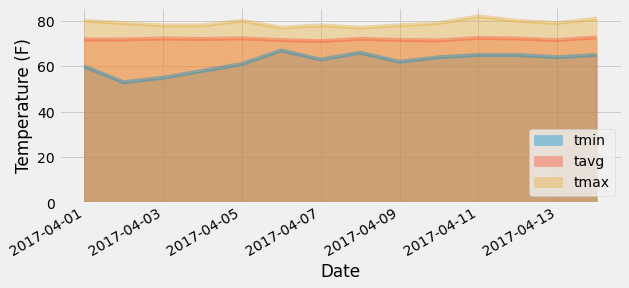

In [32]:
# Plot the daily normals as an area plot with `stacked=False`

trip_df.plot(kind='area', stacked=False, x_compat=True, alpha=.4)
#plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.legend(loc='lower right')
